In [1]:
"""Example EEG preprocessing of EMOTIV data
This example script demonstrates a few basic functions to import and annotate EEG data collected from EmotivPRO software. It uses MNE to load an XDF file, print some basic metadata, create an `info` object and plot the power spectrum."""

import pyxdf
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
from mne.time_frequency import tfr_multitaper
import warnings

In [23]:
# Path to your XDF file
# data_path
data_path = r"F:\360MoveData\CurrentStudy\sub-P826\ses-S00\eeg\sub-P826_ses-S00_task-Default[_acq-]_run-001_eeg.xdf"

# Load the XDF file
streams, fileheader = pyxdf.load_xdf(data_path)
print("XDF File Header:", fileheader)
print("Number of streams found:", len(streams))

# Iterate through all streams to print their metadata
for i, stream in enumerate(streams):
    print(f"\nStream {i+1} Metadata:")
    print("Stream Name:", stream['info']['name'][0])  # Display stream name
    print("Stream Type:", stream['info']['type'][0])  # Display stream type
    print("Number of Channels:", stream['info']['channel_count'][0])
    print("Sampling Rate:", float(stream['info']['nominal_srate'][0]))
    print("Number of Samples:", len(stream['time_series']))

    # Check if 'desc' is not None and is a list with at least one item, and the first item is not None
    if stream['info'].get('desc') and isinstance(stream['info']['desc'], list) and len(stream['info']['desc']) > 0 and stream['info']['desc'][0] is not None:
        # Check if 'channels' exists in the first element of 'desc'
        if 'channels' in stream['info']['desc'][0]:
            channel_names = [chan['label'][0] for chan in stream['info']['desc'][0]['channels'][0]['channel']]
            print("Channel Names:", channel_names)
        else:
            print("No channel names available in 'channels'.")
    else:
        print("No 'desc' or 'channels' information available.")

XDF File Header: {'info': defaultdict(<class 'list'>, {'version': ['1.0'], 'datetime': ['2024-08-27T00:03:45+1000']})}
Number of streams found: 1

Stream 1 Metadata:
Stream Name: ShimmerGSRPPG
Stream Type: GSR_PPG
Number of Channels: 7
Sampling Rate: 1.0
Number of Samples: 35
Channel Names: ['Timestamp', 'AccelX', 'AccelY', 'AccelZ', 'GSR', 'GSR_Conductance', 'PPG']


In [24]:
# Example: Choose a specific stream index
stream_index_to_extract = 0  # You can change this index to the stream you want to extract

# Ensure the selected stream exists
if stream_index_to_extract < len(streams):
    selected_stream = streams[stream_index_to_extract]
    
    # Extract data from the selected stream
    data = np.array(selected_stream['time_series']).T
    timestamps = np.array(selected_stream['time_stamps'])
    
    # Get channel names if available
    if selected_stream['info'].get('desc') and isinstance(selected_stream['info']['desc'], list) and len(selected_stream['info']['desc']) > 0 and selected_stream['info']['desc'][0] is not None:
        if 'channels' in selected_stream['info']['desc'][0]:
            channel_names = [chan['label'][0] for chan in selected_stream['info']['desc'][0]['channels'][0]['channel']]
        else:
            channel_names = ["Unnamed Channel"] * int(selected_stream['info']['channel_count'][0])
    else:
        channel_names = ["Unnamed Channel"] * int(selected_stream['info']['channel_count'][0])
    
    # Get the sampling frequency
    sfreq = float(selected_stream['info']['nominal_srate'][0])

    # Print the extracted data information
    print("\nExtracted Data from Selected Stream:")
    print("Stream Name:", selected_stream['info']['name'][0])
    print("Stream Type:", selected_stream['info']['type'][0])
    print("Number of Channels:", selected_stream['info']['channel_count'][0])
    print("Sampling Rate:", sfreq)
    print("Number of Samples:", len(data))

    # Format the first 10 data points to be more readable
    formatted_data = np.array([[format(val, ".6f") for val in row] for row in data[:, :1000]])
    
    # Print the formatted data
    print("First 10 data points (formatted):")
    for i, row in enumerate(formatted_data):
        print(f"Channel {i+1}: {row}")

    print("Channel Names:", channel_names)
else:
    print("Error: Selected stream index is out of range.")


Extracted Data from Selected Stream:
Stream Name: ShimmerGSRPPG
Stream Type: GSR_PPG
Number of Channels: 7
Sampling Rate: 1.0
Number of Samples: 7
First 10 data points (formatted):
Channel 1: ['1724681027584.000000' '1724681027584.000000' '1724681027584.000000'
 '1724681027584.000000' '1724681027584.000000' '1724681027584.000000'
 '1724681027584.000000' '1724681027584.000000' '1724681027584.000000'
 '1724681027584.000000' '1724681027584.000000' '1724681027584.000000'
 '1724681027584.000000' '1724681027584.000000' '1724681027584.000000'
 '1724681027584.000000' '1724681027584.000000' '1724681027584.000000'
 '1724681027584.000000' '1724681027584.000000' '1724681027584.000000'
 '1724681027584.000000' '1724681027584.000000' '1724681027584.000000'
 '1724681027584.000000' '1724681027584.000000' '1724681027584.000000'
 '1724681027584.000000' '1724681027584.000000' '1724681027584.000000'
 '1724681027584.000000' '1724681027584.000000' '1724681027584.000000'
 '1724681027584.000000' '172468102758

## Stream 1 GSR + PPG

In [25]:
# Example: Choose a specific stream index
stream_index_to_extract = 0  # You can change this index to the stream you want to extract

# Ensure the selected stream exists
if stream_index_to_extract < len(streams):
    selected_stream = streams[stream_index_to_extract]
    
    # Extract data from the selected stream
    data = np.array(selected_stream['time_series']).T
    timestamps = np.array(selected_stream['time_stamps'])
    
    # Check if timestamps might be in milliseconds instead of seconds
    # If the first timestamp is very large, assume it is in milliseconds and convert to seconds
    if timestamps[0] > 1e10:  # This threshold helps detect if timestamps are likely in milliseconds
        print("Warning: Timestamps appear to be in milliseconds, converting to seconds.")
        timestamps = timestamps / 1000.0  # Convert milliseconds to seconds
    
    # Get channel names if available
    if selected_stream['info'].get('desc') and isinstance(selected_stream['info']['desc'], list) and len(selected_stream['info']['desc']) > 0 and selected_stream['info']['desc'][0] is not None:
        if 'channels' in selected_stream['info']['desc'][0]:
            channel_names = [chan['label'][0] for chan in selected_stream['info']['desc'][0]['channels'][0]['channel']]
        else:
            channel_names = ["Unnamed Channel"] * int(selected_stream['info']['channel_count'][0])
    else:
        channel_names = ["Unnamed Channel"] * int(selected_stream['info']['channel_count'][0])
    
    # Get the sampling frequency
    sfreq = float(selected_stream['info']['nominal_srate'][0])

    # Print the extracted data information
    print("\nExtracted Data from Selected Stream:")
    print("Stream Name:", selected_stream['info']['name'][0])
    print("Stream Type:", selected_stream['info']['type'][0])
    print("Number of Channels:", selected_stream['info']['channel_count'][0])
    print("Sampling Rate:", sfreq)
    print("Number of Samples:", len(data))
    print("First 5 data points:", data[:, :5])  # Transposed to match channels x samples format
    print("Channel Names:", channel_names)
    print("First 5 Timestamps (after conversion if any):", timestamps[:5])  # Display the first 5 timestamps after conversion
else:
    print("Error: Selected stream index is out of range.")



Extracted Data from Selected Stream:
Stream Name: ShimmerGSRPPG
Stream Type: GSR_PPG
Number of Channels: 7
Sampling Rate: 1.0
Number of Samples: 7
First 5 data points: [[ 1.7246810e+12  1.7246810e+12  1.7246810e+12  1.7246810e+12
   1.7246810e+12]
 [-5.4239130e+00 -5.4347825e+00 -5.4021740e+00 -5.4347825e+00
  -5.4130435e+00]
 [ 1.8043479e+00  1.8260870e+00  1.8152174e+00  1.8478261e+00
   1.8152174e+00]
 [ 7.2717390e+00  7.2717390e+00  7.2500000e+00  7.2717390e+00
   7.2608695e+00]
 [ 1.4530645e+05  1.3650000e+05  1.2174324e+05  1.0986585e+05
   1.0475581e+05]
 [ 6.8820068e-03  7.3260074e-03  8.2140081e-03  9.1020092e-03
   9.5460098e-03]
 [ 4.3956043e+01  4.6153847e+01  4.6886448e+01  4.6153847e+01
   4.7619049e+01]]
Channel Names: ['Timestamp', 'AccelX', 'AccelY', 'AccelZ', 'GSR', 'GSR_Conductance', 'PPG']
First 5 Timestamps (after conversion if any): [269193.52907301 269194.53033511 269195.53159722 269196.53285932
 269197.53412142]


## Stream 2 and Stream 3: EEG Emotiv

In [21]:
# Extract and transpose data (channels x samples)
data = np.array(selected_stream['time_series']).T

# Handle zero and infinite values
data[np.isinf(data)] = np.nan  # Replace infinite values with NaN
data = np.nan_to_num(data, nan=0.0)  # Replace NaN with zero

# Get channel names
if selected_stream['info'].get('desc') and isinstance(selected_stream['info']['desc'], list) and len(selected_stream['info']['desc']) > 0 and selected_stream['info']['desc'][0] is not None:
    if 'channels' in selected_stream['info']['desc'][0]:
        channel_names = [chan['label'][0] for chan in selected_stream['info']['desc'][0]['channels'][0]['channel']]
    else:
        channel_names = ["Unnamed Channel"] * int(selected_stream['info']['channel_count'][0])
else:
    channel_names = ["Unnamed Channel"] * int(selected_stream['info']['channel_count'][0])

# Get the sampling frequency
sfreq = float(selected_stream['info']['nominal_srate'][0])

# Remove problematic and non-EEG channels
bad_channels = ['Interpolate', 'HardwareMarker', 'Markers', 'Timestamp', 'Counter']
picks = [i for i, name in enumerate(channel_names) if name not in bad_channels]
data = data[picks, :]
channel_names = [channel_names[i] for i in picks]
channel_types = ['eeg'] * len(channel_names)  # Update channel_types to match the filtered channel_names

# Create MNE info object
info = mne.create_info(channel_names, sfreq, channel_types)

# Create RawArray object for raw data
raw = mne.io.RawArray(data, info)

# Print out some basic information about the RawArray
print(raw)

Creating RawArray with float64 data, n_channels=32, n_times=29710
    Range : 0 ... 29709 =      0.000 ...   232.102 secs
Ready.
<RawArray | 32 x 29710 (232.1 s), ~7.3 MB, data loaded>


In [22]:
# Create a copy of the raw data for filtering
raw_filtered = raw.copy()

# Set standard montage for channel locations
montage = mne.channels.make_standard_montage('standard_1020')
raw_filtered.set_montage(montage)  # Ensure montage is set

# Apply high-pass filter to remove DC offset and baseline drift
raw_filtered.filter(1., None, fir_design='firwin')

# Apply band-pass filter to remove low and high frequency noise
raw_filtered.filter(1., 50., fir_design='firwin')

# Apply notch filter to remove power line noise
raw_filtered.notch_filter(np.arange(50, sfreq / 2, 50), fir_design='firwin')

# Remove linear trend to further reduce baseline drift
raw_filtered.apply_function(lambda x: mne.filter.detrend(x, axis=-1))

# Re-reference the data to average
raw_filtered.set_eeg_reference('average', projection=True)
raw_filtered.apply_proj()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,32 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,1.00 Hz
Lowpass,50.00 Hz


In [23]:
# Compute power spectral density (PSD) for original and filtered data
psd_original = raw.compute_psd(fmax=50)
psd_filtered = raw_filtered.compute_psd(fmax=50)

# Get PSD data and frequencies
psd_data_original, freqs = psd_original.get_data(return_freqs=True)
psd_data_filtered, freqs = psd_filtered.get_data(return_freqs=True)

Effective window size : 16.000 (s)
Effective window size : 16.000 (s)


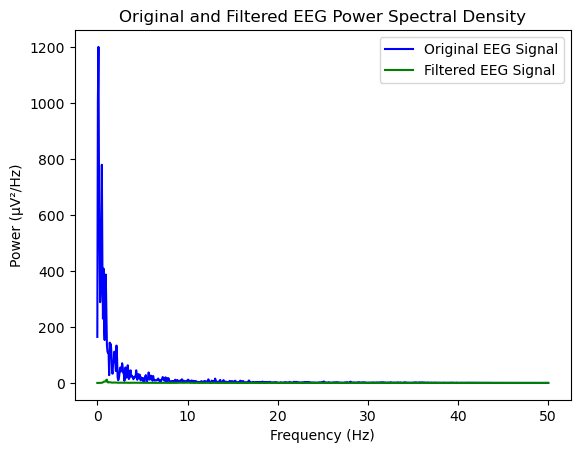

In [24]:
# Plot original and filtered PSD on the same plot
plt.figure()
plt.plot(freqs, np.mean(psd_data_original, axis=0), label='Original EEG Signal', color='blue')
plt.plot(freqs, np.mean(psd_data_filtered, axis=0), label='Filtered EEG Signal', color='green')
plt.title('Original and Filtered EEG Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (µV²/Hz)')
plt.legend()
plt.show()

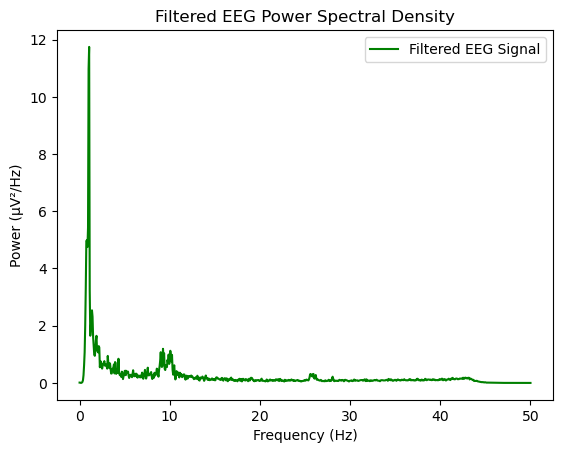

In [25]:

# Plot only filtered PSD
plt.figure()
plt.plot(freqs, np.mean(psd_data_filtered, axis=0), label='Filtered EEG Signal', color='green')
plt.title('Filtered EEG Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (µV²/Hz)')
plt.legend()
plt.show()

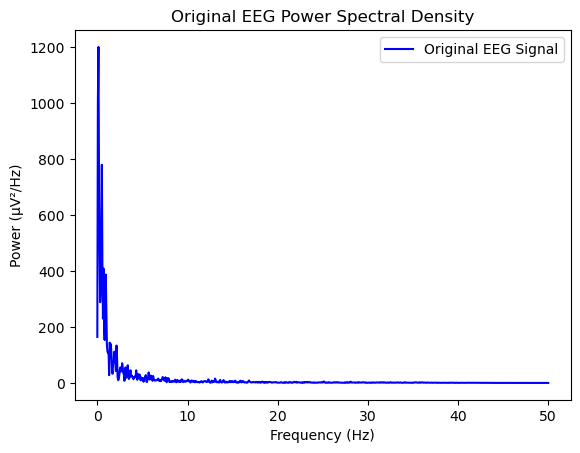

In [26]:
# Plot only original PSD
plt.figure()
plt.plot(freqs, np.mean(psd_data_original, axis=0), label='Original EEG Signal', color='blue')
plt.title('Original EEG Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (µV²/Hz)')
plt.legend()
plt.show()

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


Applying baseline correction (mode: logratio)


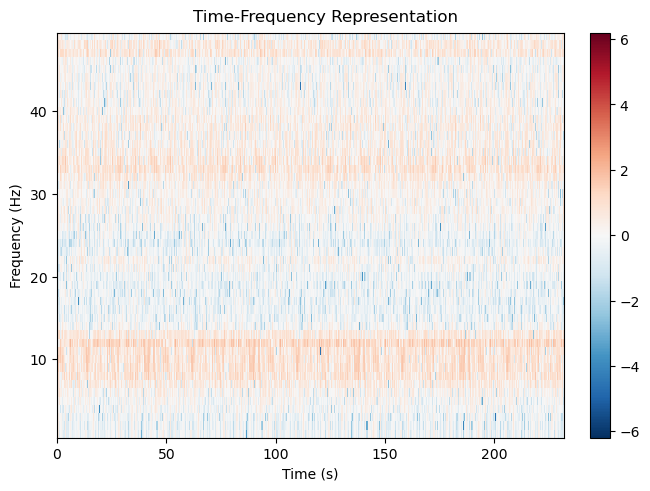

[<Figure size 640x480 with 2 Axes>]

In [27]:
# Define frequency range for time-frequency analysis
freqs = np.arange(1, 50, 1)  # 1 to 50 Hz
n_cycles = freqs / 2.  # Number of cycles in each frequency

# Compute time-frequency representation using multitaper method
power = tfr_multitaper(raw_filtered, freqs=freqs, n_cycles=n_cycles, time_bandwidth=2.0, return_itc=False)

# Plot the time-frequency representation
power.plot([0], baseline=(None, 0), mode='logratio', title='Time-Frequency Representation')

## 1.Low-Frequency Band (0-10 Hz):
- The low-frequency band shows relatively higher power, especially in the 0-10 Hz range. 
- This may correspond to delta and theta wave activity, which are typically associated with sleep, deep relaxation, or certain pathological states.

## 2.Mid-Frequency Band (10-20 Hz):
- The mid-frequency band exhibits more complex power changes, especially in the 10-20 Hz range. 
- This may correspond to alpha and low beta wave activity. 
- Alpha waves are typically prominent during relaxed, awake states, while beta waves are associated with alertness and cognitive activity.

## 3.High-Frequency Band (20-50 Hz):
- The high-frequency band shows relatively fewer power changes and remains mostly stable. 
- These frequencies correspond to high beta and gamma waves, often associated with high cognitive load and information processing.

In [28]:
# Import necessary libraries for plotting
from mne.viz import plot_topomap
from mne.time_frequency import psd_array_multitaper

In [29]:
# Compute power spectral density (PSD) for the filtered data
psds, freqs = psd_array_multitaper(raw_filtered.get_data(), sfreq=raw_filtered.info['sfreq'], fmax=50, n_jobs=1)

    Using multitaper spectrum estimation with 7 DPSS windows


In [31]:
# Plot topomap for specific frequency bands
bands = {'Delta (1-4 Hz)': (1, 4),
         'Theta (4-8 Hz)': (4, 8),
         'Alpha (8-12 Hz)': (8, 12),
         'Beta (12-30 Hz)': (12, 30),
         'Gamma (30-50 Hz)': (30, 50)}

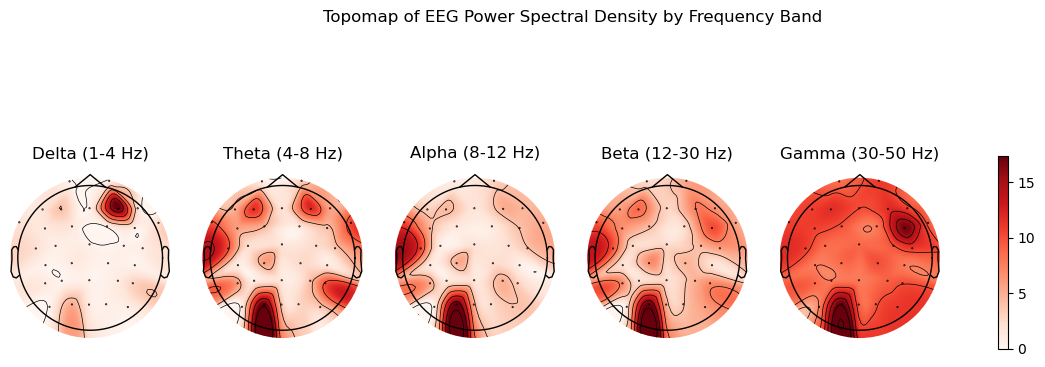

In [32]:
fig, axes = plt.subplots(1, len(bands), figsize=(15, 5))

for ax, (band, (fmin, fmax)) in zip(axes, bands.items()):
    # Find the frequencies within the desired band
    idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
    
    # Average the PSDs within this band
    psd_band = psds[:, idx_band].mean(axis=1)
    
    # Plot topomap
    im, _ = plot_topomap(psd_band, raw_filtered.info, axes=ax, show=False)
    ax.set_title(band)

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
plt.suptitle('Topomap of EEG Power Spectral Density by Frequency Band')
plt.show()

## The topomap plots show the distribution of power across the scalp for different frequency bands.
- The Delta band (1-4 Hz) shows higher power in frontal regions, often associated with deep sleep or slow-wave activity.
- The Theta band (4-8 Hz) has higher power in central and temporal regions, linked to relaxation or light sleep.
- The Alpha band (8-12 Hz) shows increased power in posterior regions, typically associated with relaxed wakefulness.
- The Beta band (12-30 Hz) exhibits higher power in frontal and central regions, correlated with active thinking and alertness.
- The Gamma band (30-50 Hz) has more power in frontal areas, often linked to high-level cognitive functions.

Applying baseline correction (mode: logratio)


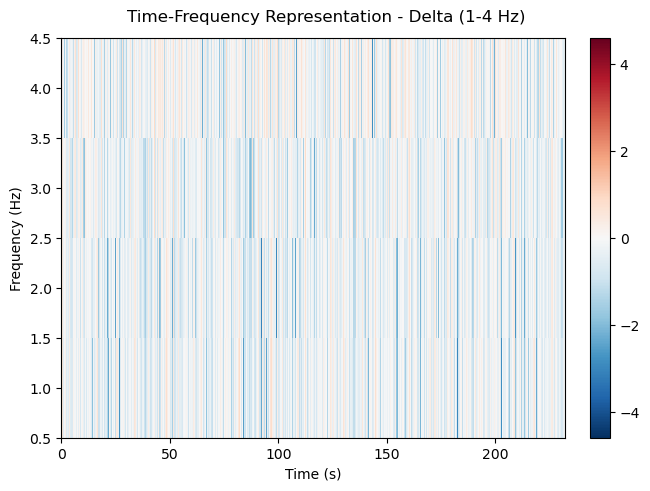

Applying baseline correction (mode: logratio)


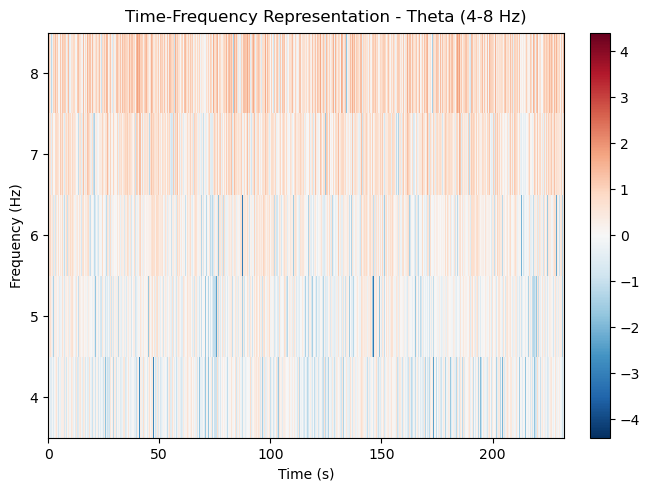

Applying baseline correction (mode: logratio)


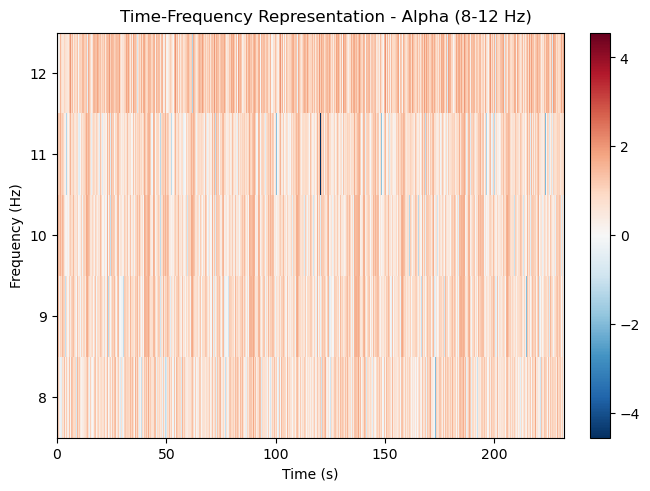

Applying baseline correction (mode: logratio)


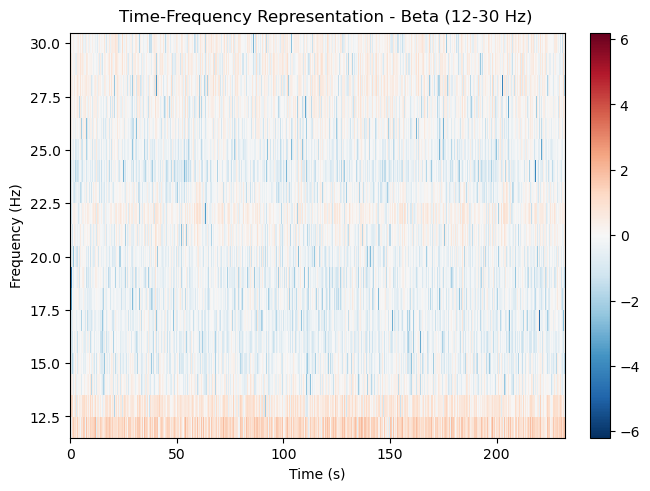

Applying baseline correction (mode: logratio)


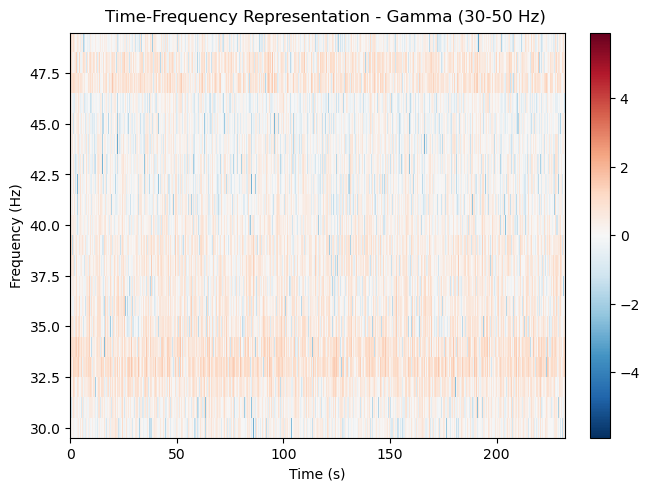

In [33]:
# Plot time-frequency representation for specific frequency bands
for band, (fmin, fmax) in bands.items():
    power.plot([0], baseline=(None, 0), mode='logratio', fmin=fmin, fmax=fmax, title=f'Time-Frequency Representation - {band}')